## Task 1 MLP Part 2 - Tokenizered Words and Embedding Approach

In [2]:
# Convert glove text to word2vec format if it does'nt already exist
from os.path import exists
from gensim.scripts.glove2word2vec import glove2word2vec
glove_input_file = 'glove.6B.300d.txt'
word2vec_file = 'glove.6B.300d.txt.word2vec'

if not exists(word2vec_file):
    print("Creating file in glove format")
    glove2word2vec(glove_input_file, word2vec_file)

In [3]:
import pandas as pd
import numpy as np

# Function to load the training and test datasets
# Returns data in the format x_train, y_train, x_test, y_test
def load_dataset():
    train_df = pd.read_csv('traindrug.csv')
    test_df = pd.read_csv('testdrug.csv')

    x_train = train_df.values[:, 0]
    y_train = train_df.values[:, 1].astype(np.int32)

    x_test = test_df.values[:, 0]
    y_test = test_df.values[:, 1].astype(np.int32)

    return x_train, y_train, x_test, y_test

In [4]:
x_train, y_train, x_test, y_test = load_dataset()

# Confirming expected data sizes
print("Length: x_train:", len(x_train))
print("Length: y_train:", len(y_train))
print("Length: x_test:", len(x_test))
print("Length: y_test:", len(y_test))

assert len(x_train) == 1000
assert len(y_train) == 1000
assert len(x_test) == 500
assert len(y_test) == 500

Length: x_train: 1000
Length: y_train: 1000
Length: x_test: 500
Length: y_test: 500


In [5]:
# Load word to vec glove file 
from gensim.models import KeyedVectors
glove_vectors = KeyedVectors.load_word2vec_format(word2vec_file, binary=False)

In [6]:
# Setup tokenizer and fit to training data
# Imports for converting data to tokenized integers for embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=50000)
tokenizer.fit_on_texts(x_train)

train_sequences = tokenizer.texts_to_sequences(x_train)

number_of_words = len(tokenizer.word_index) + 1

# Determine the max word count in a sample in x_train
sentence_word_counts = []
for x in x_train:
    sentence_word_counts.append(len(x.split()))
max_word_count = max(sentence_word_counts) + 10 # Adding more if max_word_count in test is larger 
print("Maximum words in a sentence in x_train:", max_word_count)

# Pad all sequences to the same length
x_train_seq = pad_sequences(sequences=train_sequences, maxlen=max_word_count)

# Also create and pad the sequence for test data
test_sequences = tokenizer.texts_to_sequences(x_test)
x_test_seq = pad_sequences(sequences=test_sequences, maxlen=max_word_count)

# Lastly convert all sequences to a numpy float array
x_train_seq = np.asarray(x_train_seq).astype(np.float32)
x_test_seq = np.asarray(x_test_seq).astype(np.float32)

print(x_train_seq.shape)

Maximum words in a sentence in x_train: 310
(1000, 310)


In [7]:
# Define weight matrix for embedding and populate with glove vector at for each word
embedded_weight_matrix = np.zeros((number_of_words, 300))

for word, i in tokenizer.word_index.items():
    if word in glove_vectors:
        embedding_vector = glove_vectors[word]
        embedded_weight_matrix[i] = embedding_vector

# Test the matrix compare word at index 0
print(embedded_weight_matrix.shape)
print(np.array_equal(embedded_weight_matrix[1] ,glove_vectors['i']))

(5626, 300)
True


Epoch 1/10
32/32 [==============================] - 4s 121ms/step - loss: 0.4393 - accuracy: 0.3340 - val_loss: 0.4205 - val_accuracy: 0.3900
Epoch 2/10
32/32 [==============================] - 4s 126ms/step - loss: 0.3469 - accuracy: 0.5230 - val_loss: 0.4294 - val_accuracy: 0.3620
Epoch 3/10
32/32 [==============================] - 4s 124ms/step - loss: 0.1836 - accuracy: 0.7750 - val_loss: 0.4110 - val_accuracy: 0.4080
Epoch 4/10
32/32 [==============================] - 4s 122ms/step - loss: 0.0755 - accuracy: 0.9080 - val_loss: 0.4092 - val_accuracy: 0.4000
Epoch 5/10
32/32 [==============================] - 4s 123ms/step - loss: 0.0302 - accuracy: 0.9640 - val_loss: 0.4108 - val_accuracy: 0.3920
Epoch 6/10
32/32 [==============================] - 4s 123ms/step - loss: 0.0157 - accuracy: 0.9810 - val_loss: 0.4159 - val_accuracy: 0.3800
Epoch 7/10
32/32 [==============================] - 4s 124ms/step - loss: 0.0082 - accuracy: 0.9910 - val_loss: 0.4151 - val_accuracy: 0.3760
Epoch 

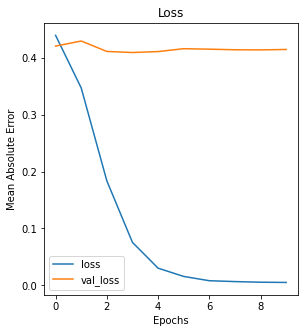

In [37]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

# Define a model
mlp_model = Sequential()
mlp_model.add(Embedding(input_dim=number_of_words, output_dim=300, weights=[embedded_weight_matrix], input_length=max_word_count, trainable=True))
mlp_model.add(Flatten())
mlp_model.add(Dense(200, activation='relu', kernel_initializer='random_uniform', bias_initializer='zeros'))
mlp_model.add(Dense(3, activation='softmax', kernel_initializer='random_uniform', bias_initializer='zeros'))

opt = Adam(learning_rate=0.0005)

mlp_model.compile(optimizer=opt, loss='mean_absolute_error', metrics=['accuracy'])

# As the output is softmax the label must be encoded to a 1x3 matrix
# Subtract 1 for the labels to get them as an array starting from class 0
y_train_cat = to_categorical(y_train - 1)
y_test_cat = to_categorical(y_test - 1)

# Run the model against the computed vectors
epochs = 10
history = mlp_model.fit(x_train_seq, y_train_cat, epochs=epochs, verbose=1, validation_data=(x_test_seq, y_test_cat))

final_loss, final_acc = mlp_model.evaluate(x_test_seq, y_test_cat)
print("Final accuracy on test: {}".format(final_acc))
print('Final loss on test: ', final_loss)

# Evaluation of softmax approach
import matplotlib.pyplot as plt 
plt.rcParams['figure.figsize'] = [10, 5]
plt.subplot(1,2,1)
plt.plot(range(epochs), history.history['loss'], label='loss')
plt.plot(range(epochs), history.history['val_loss'], label='val_loss')
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error")
plt.legend()
plt.show()
